In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import glob, os, gc
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import KFold

# Add the path to the directory containing the module
import sys
sys.path.append('../../')
from util.ml import baseline, metrics, nestedMLR, fno

from properscoring import crps_ensemble  # For CRPS calculation
from sklearn.utils import resample  # For bootstrapping

## Settings

In [13]:
# Find the folder name organized by seed number
seed_doc = sorted(glob.glob('../../datas/seed_revised_*/'))[0]

# Load the data
# Load the time series data
df = pd.read_csv(seed_doc +'X_train_ts_all.csv')
df_valid = pd.read_csv(seed_doc +'X_validation_ts_all.csv')
df_test = pd.read_csv(seed_doc +'X_test_ts_all.csv')

# Find the name for each column
column_names = ([obj.split('_step_')[0] for obj in df.columns])
# Unique names in the column name list
unique_names = list(set(column_names))
# Remove strings with large_scale
unique_names_filt = [var for var in unique_names if "large_scale" not in var]
#tofilt = ['_10_', '_20_', '_30_', '_50_', '_70_']
#remaining_vars = [var for var in remaining_vars if not any(substring in var for substring in tofilt)] # Filter out specific pressure levels

# Now we read in the y data for every fold
y_train = []
y_val = []
for i in range(7):
    y_train.append(baseline.load_pickle(f'../../datas/proc/sfs/y/ytrain_split_{i}.pkl'))
    y_val.append(baseline.load_pickle(f'../../datas/proc/sfs/y/yval_split_{i}.pkl'))

pcs_train = baseline.load_pickle(f'../../datas/proc/sfs/pcsall_smooth_train.pkl')
pcs_val = baseline.load_pickle(f'../../datas/proc/sfs/pcsall_smooth_valid.pkl')

Filtered feature list

In [4]:
expttype = 'cdf'
filted_feature = baseline.load_pickle(f'../../datas/proc/sfs/results/best_linear_{expttype}_feature.pkl')

Construct inputs for the nestedMLR model

In [6]:
def select_subset_X(pcs_train,pcs_val,y_train,iseed,selected_pcs,pcnum):
    X_train_subset = [pcs_train[iseed][sel_var][:,:pcnum] for sel_var, _ in selected_pcs]
    X_val_subset = [pcs_val[iseed][sel_var][:,:pcnum] for sel_var, _ in selected_pcs]
    return X_train_subset, X_val_subset

In [7]:
X_train_subset, X_val_subset = [],[]
for i in range(7):
    X_train, X_val = select_subset_X(pcs_train,pcs_val,y_train,i,filted_feature,10)
    X_train_subset.append(X_train)
    X_val_subset.append(X_val)

In [8]:
sizes = [obj.shape[1] for obj in X_train_subset[0]]

## Train nestedMLR

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
from natsort import natsorted
def r2_score_f(y_true,y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    r2 = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
    return r2

In [10]:
def get_metrics(y_true,y_pred):
    rmse = mean_squared_error(y_true,y_pred,squared=False)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score_f(y_true,y_pred)
    return rmse, mae, r2

def test_model(X_train_subset,y_train,X_val_subset,y_val):
    # Fit the model
    model = linear_model.LinearRegression()
    model.fit(X_train_subset,y_train)
    y_pred = model.predict(X_val_subset)
    rmse, mae, r2 = get_metrics(y_val,y_pred)
    return rmse, mae, r2

In [37]:
store_stats = []
for j in range(7):
    models, val_rmses, train_rmses, val_r2, train_r2 = [],[],[],[],[]
    for i in tqdm(range(1, 3)):#5)):
        #model = nestedMLR.nestedMLR_var_global(sizes[:i],4, 3)
        #model = nestedMLR.nestedMLR_var_global_l1l2(sizes[:i],1, 5, 'l2', 0.25)
        #model = nestedMLR.nestedMLR_VED(sizes[:i], [int(obj) for obj in np.ones(len(sizes))][:i], seed=3, bounds=2, reg_type='L2', reg_coeff=0)
        model.fit(np.hstack(X_train_subset[j][:i]), y_train[j]['cdf'],  1000)
        models.append(model)
        y_trainpred = model.predict(np.hstack(X_train_subset[j][:i]))
        y_valpred = model.predict(np.hstack(X_val_subset[j][:i]))
        val_rmses.append(mean_squared_error(y_val[j]['cdf'], y_valpred, squared=False))
        train_rmses.append(mean_squared_error(y_train[j]['cdf'], y_trainpred, squared=False))
        val_r2.append(r2_score_f(y_val[j]['cdf'], y_valpred))
        train_r2.append(r2_score_f(y_train[j]['cdf'], y_trainpred))
    store_stats.append({'model': models, 'val_rmses': val_rmses, 'train_rmses': train_rmses, 'val_r2': val_r2, 'train_r2': train_r2})

  0%|          | 0/2 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [78]:
baseline.save_models(store_stats,f'../../datas/proc/sfs/results/nestedMLR_cdf_l2_0_3_model.pkl')
#baseline.save_models(store_stats,f'../../datas/proc/sfs/results/nestedMLR_cdf_l1_0_2_model.pkl')

Individual PC feature selection

In [23]:
indivi_PC = [1.2435651991490098,1.2211574318397695,1.198769814548267,1.185032452186465,1.1774943814991075]

ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

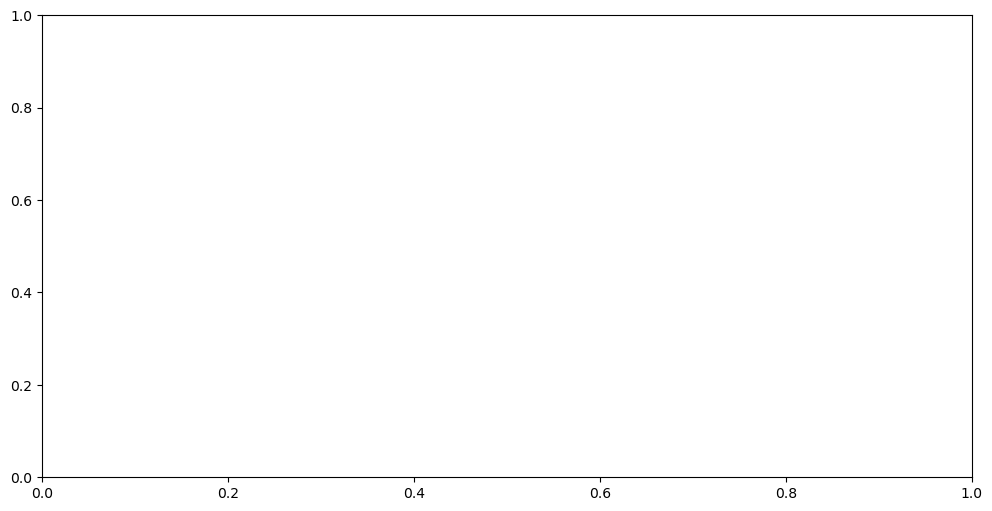

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(np.arange(1, 6, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(2)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 6, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(2)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 6, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(2)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(2)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(2)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(2)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.335407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 4, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

In [36]:
np.mean(np.asarray([obj['val_rmses'] for obj in store_stats]),axis=0)

array([1.27167011, 1.2716656 ])

In [123]:
np.mean(np.asarray([obj['val_rmses'] for obj in store_stats]),axis=0)

array([1.27093593, 1.26835282])

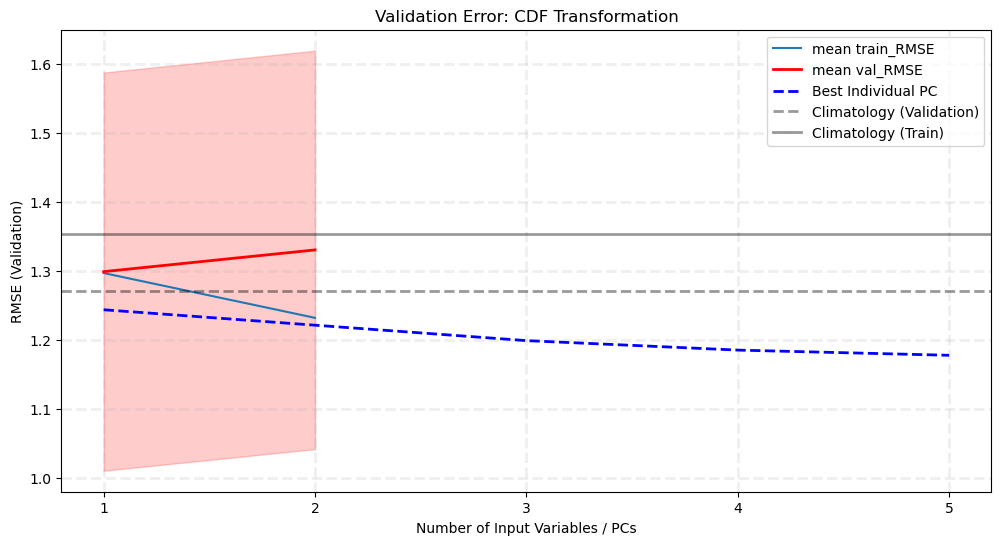

In [115]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
idxx = 2
ax.plot(np.arange(1, 3, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 3, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 3, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.271407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

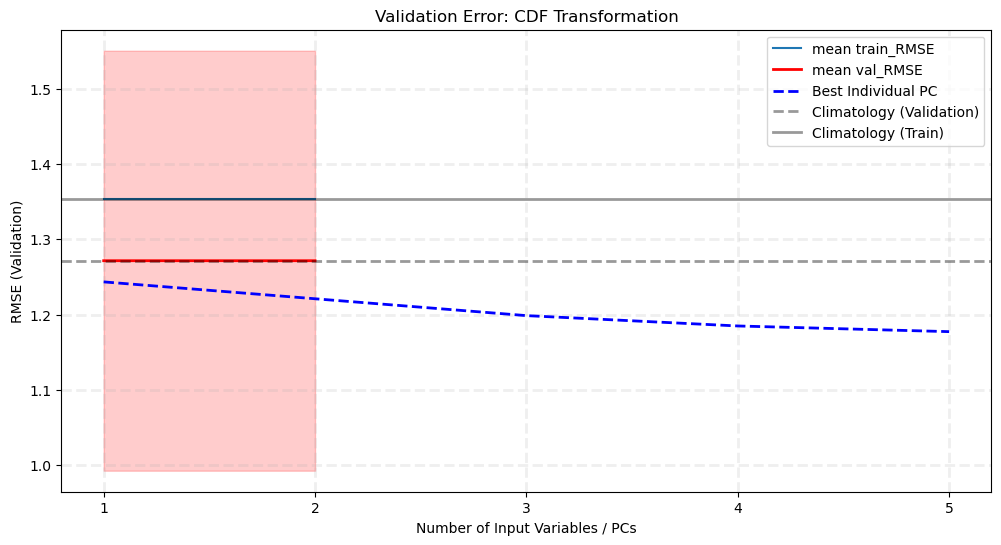

In [31]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
idxx = 2
ax.plot(np.arange(1, 3, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 3, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 3, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.271407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

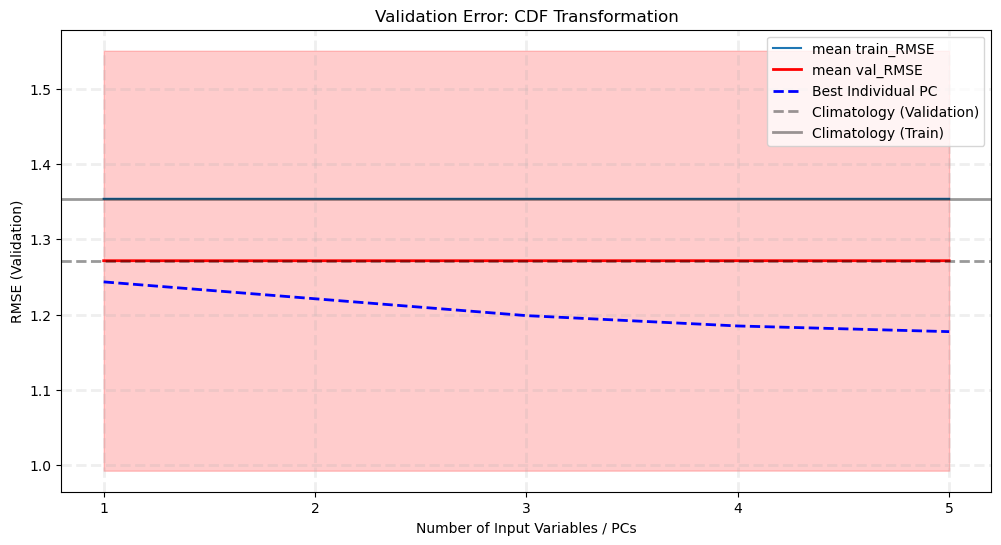

In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
idxx = 5
ax.plot(np.arange(1, 6, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 6, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 6, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.271407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

l1 regularization: 0.2

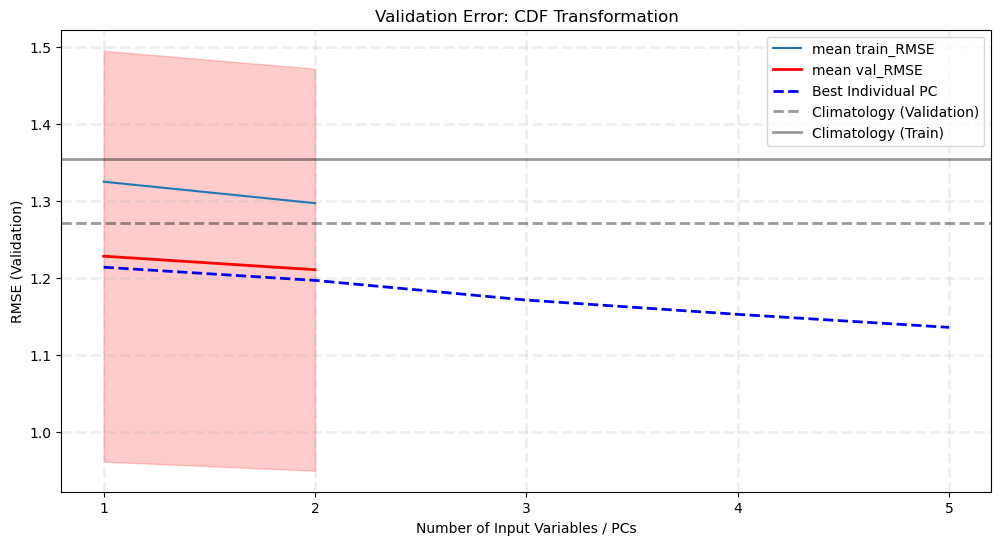

In [39]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
idxx = 2
ax.plot(np.arange(1, 3, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 3, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 3, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.271407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

IndexError: list index out of range

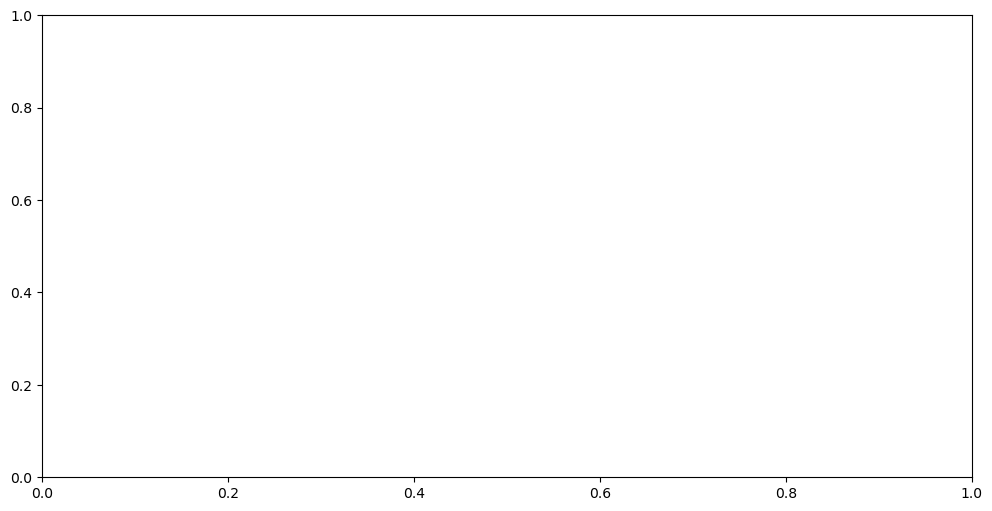

In [38]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
idxx = 4
ax.plot(np.arange(1, idxx+1, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, idxx+1, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, idxx+1, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(idxx)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.271407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

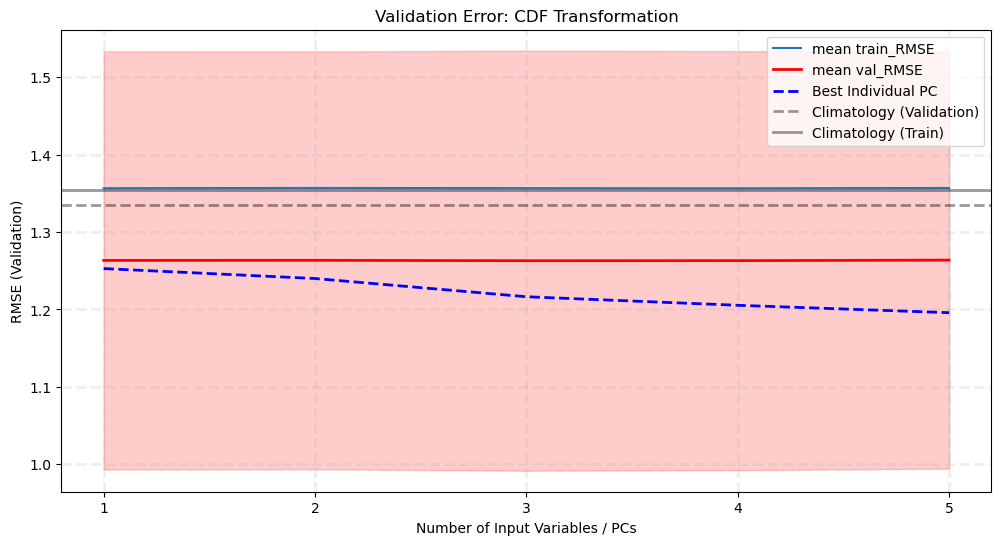

In [11]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(np.arange(1, 6, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(5)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 6, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(5)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 6, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(5)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(5)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(5)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(5)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 6, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.335407045719028, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

In [21]:
y_pred = model.predict(np.hstack(X_val_subset[0]))

In [22]:
val_rmse = mean_squared_error(y_val[0]['cdf'], y_pred, squared=False)

In [23]:
val_rmse

1.14099648463094

In [14]:
val_rmse

2.9953986846204717

In [19]:
np.hstack(X_train_subset[0][:2]).shape

(48, 22)

### Read trained models

In [9]:
# Read trained models
models = [baseline.load_pickle(obj) for obj in glob.glob('../../datas/proc/sfs/nestedMLR/nestedMLR_cdf/*')]
models_max = [baseline.load_pickle(obj) for obj in glob.glob('../../datas/proc/sfs/nestedMLR/nestedMLR_max/*')]

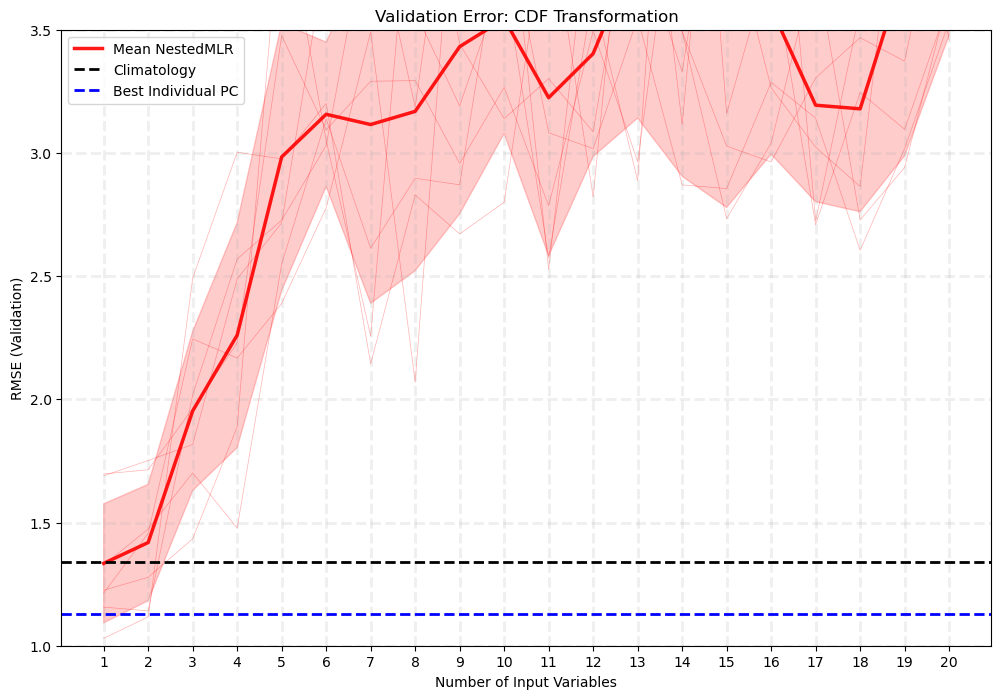

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
for i in range(7):
    plt.plot(np.arange(1, 21, 1),models[i]['val_rmses'],lw=0.5,alpha=0.3,c='r')
plt.plot(np.arange(1, 21, 1),np.asarray([models[i]['val_rmses'] for i in range(7)]).mean(axis=0),lw=2.5,alpha=0.9,c='r',label='Mean NestedMLR')
# Shaded area between the upper and lower bounds
plt.fill_between(np.arange(1, 21, 1),np.asarray([models[i]['val_rmses'] for i in range(7)]).mean(axis=0)+np.asarray([models[i]['val_rmses'] for i in range(7)]).std(axis=0),
                    np.asarray([models[i]['val_rmses'] for i in range(7)]).mean(axis=0)-np.asarray([models[i]['val_rmses'] for i in range(7)]).std(axis=0),color='r',alpha=0.2)
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=1.34, color='k', linestyle='--',lw=2,label='Climatology')
plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 21, 1))
plt.ylim(1,3.5)
plt.xlabel('Number of Input Variables')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: CDF Transformation')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

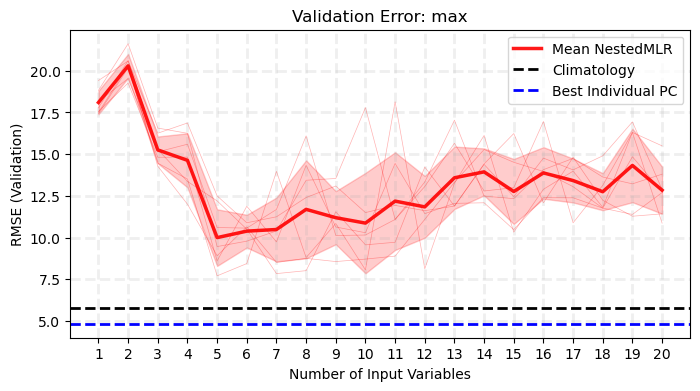

In [132]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
for i in range(7):
    plt.plot(np.arange(1, 21, 1),models_max[i]['val_rmses'],lw=0.5,alpha=0.3,c='r')
plt.plot(np.arange(1, 21, 1),np.asarray([models_max[i]['val_rmses'] for i in range(7)]).mean(axis=0),lw=2.5,alpha=0.9,c='r',label='Mean NestedMLR')
# Shaded area between the upper and lower bounds
plt.fill_between(np.arange(1, 21, 1),np.asarray([models_max[i]['val_rmses'] for i in range(7)]).mean(axis=0)+np.asarray([models_max[i]['val_rmses'] for i in range(7)]).std(axis=0),
                    np.asarray([models_max[i]['val_rmses'] for i in range(7)]).mean(axis=0)-np.asarray([models_max[i]['val_rmses'] for i in range(7)]).std(axis=0),color='r',alpha=0.2)
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=5.804041392297193, color='k', linestyle='--',lw=2,label='Climatology')
plt.axhline(y=4.833614940919053, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 21, 1))
#plt.ylim(1,3.5)
plt.xlabel('Number of Input Variables')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: max')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

In [117]:
[models[i]['val_rmses'][1] for i in range(7)]

[1.7139019325265583,
 1.1170440156762471,
 1.1412425001866362,
 1.751735140327092,
 1.473490550210853,
 1.4561287097104407,
 1.277855219369926]

In [134]:
[models_max[i]['val_rmses'][-1] for i in range(7)]

[15.495151335317196,
 11.42042129605261,
 13.798388399425875,
 12.694784375735294,
 12.728014325935003,
 12.878605887202271,
 10.862765561918897]

In [14]:

models[1]['model'][6].weights

{'dense1': array([ 0.05056171,  0.49995133, -0.99590893,  0.69359851, -0.41830152,
        -1.58457724, -0.64770677,  0.59857517,  0.33225003, -1.14747663,
         0.61866969]),
 'dense2': array([-0.08798693,  0.4250724 ,  0.33225315, -1.15681626,  0.35099715,
        -0.60688728,  1.54697933,  0.72334161,  0.04613557, -0.98299165,
         0.05443274]),
 'dense3': array([ 0.15989294, -1.20894816,  2.22336022,  0.39429521,  1.69235772,
        -1.11281215,  1.63574754, -1.36096559, -0.65122583,  0.54245131,
         0.04800625]),
 'dense4': array([-2.35807363, -1.10558404,  0.83783635,  2.08787087,  0.91484096,
        -0.27620335,  0.7965119 , -1.14379857,  0.50991978, -1.3474603 ,
        -0.0093601 ]),
 'dense5': array([-0.13070464,  0.80208661, -0.30296397,  1.20200259, -0.19674528,
         0.8365287 ,  0.78660228, -1.84087587,  0.03754749,  0.03592805,
        -0.77873992]),
 'dense6': array([ 0.17941071, -1.45553433,  0.55618522,  0.50977885,  0.30044554,
         2.47658416,  

In [124]:
# Get the coefficients of the model
MODEL_weights = models[1]['model'][1].weights

In [125]:
pcas = baseline.load_pickle('/Users/itam/windstorm/windstorm/datas/proc/sfs/pca/pcaall.pkl')
var1 = pcas[filted_feature[0][0]].components_
var2 = pcas[filted_feature[1][0]].components_

In [126]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

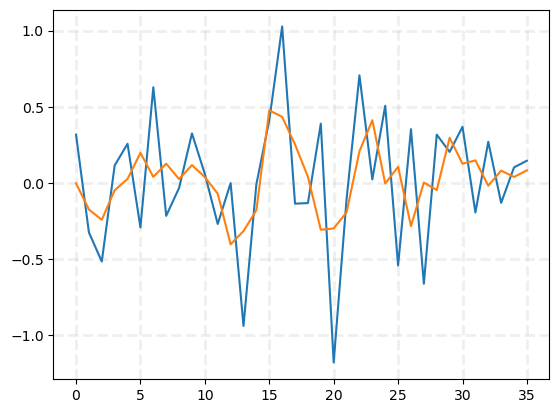

In [127]:
plt.plot(np.dot(var1[:,:11], MODEL_weights['dense1']))
# Smooth the curve
plt.plot(smooth(np.dot(var1[:,:11], MODEL_weights['dense1']), 3))
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

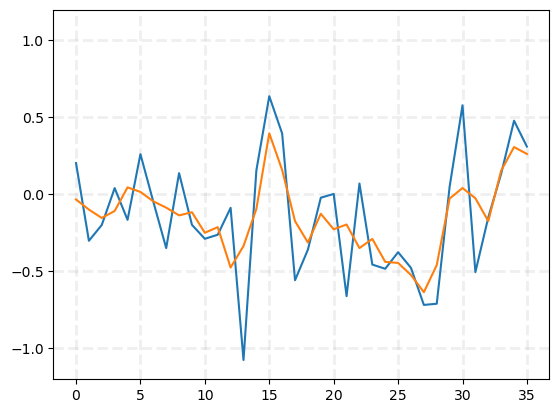

In [128]:
plt.plot(np.dot(var2[:,:11], MODEL_weights['dense2']))
plt.plot(smooth(np.dot(var2[:,:11], MODEL_weights['dense2']),3))
plt.grid(lw=2,alpha=0.2,ls='--')
plt.ylim(-1.2,1.2)
plt.show()

In [123]:
MODEL_weights

{'dense1': array([ 0.05056171,  0.49995133, -0.99590893,  0.69359851, -0.41830152,
        -1.58457724, -0.64770677,  0.59857517,  0.33225003, -1.14747663,
         0.61866969]),
 'dense2': array([-0.08798693,  0.4250724 ,  0.33225315, -1.15681626,  0.35099715,
        -0.60688728,  1.54697933,  0.72334161,  0.04613557, -0.98299165,
         0.05443274]),
 'output': array([[ 2.22336022,  0.39429521,  1.69235772, -1.11281215,  1.63574754,
         -1.36096559, -0.65122583,  0.54245131,  0.04800625, -2.35807363,
         -1.10558404,  0.83783635,  2.08787087,  0.91484096, -0.27620335],
        [ 0.7965119 , -1.14379857,  0.50991978, -1.3474603 , -0.0093601 ,
         -0.13070464,  0.80208661, -0.30296397,  1.20200259, -0.19674528,
          0.8365287 ,  0.78660228, -1.84087587,  0.03754749,  0.03592805]])}

In [129]:
MODEL_weights

{'dense1': array([ 0.05056171,  0.49995133, -0.99590893,  0.69359851, -0.41830152,
        -1.58457724, -0.64770677,  0.59857517,  0.33225003, -1.14747663,
         0.61866969]),
 'dense2': array([-0.08798693,  0.4250724 ,  0.33225315, -1.15681626,  0.35099715,
        -0.60688728,  1.54697933,  0.72334161,  0.04613557, -0.98299165,
         0.05443274]),
 'output': array([[ 2.22336022,  0.39429521,  1.69235772, -1.11281215,  1.63574754,
         -1.36096559, -0.65122583,  0.54245131,  0.04800625, -2.35807363,
         -1.10558404,  0.83783635,  2.08787087,  0.91484096, -0.27620335],
        [ 0.7965119 , -1.14379857,  0.50991978, -1.3474603 , -0.0093601 ,
         -0.13070464,  0.80208661, -0.30296397,  1.20200259, -0.19674528,
          0.8365287 ,  0.78660228, -1.84087587,  0.03754749,  0.03592805]])}